# Loads (Notice git integration)

In [0]:
!pip install pyro-ppl

     |████████████████████████████████| 522kB 5.5MB/s 


In [0]:
!nvidia-smi

Mon Jun 15 08:33:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [0]:
import matplotlib

In [0]:
# "Standard" imports
import numpy as np
from time import time
import itertools
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd

# Pytorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.distributions import TransformedDistribution

# Pyro imports
import pyro
from pyro.distributions import ConditionalTransformedDistribution, ConditionalTransformModule, TransformModule
import pyro.distributions as dist
from pyro.distributions.transforms import affine_coupling, affine_autoregressive, permute

# Sklearn imports
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Notebooks imports
from IPython.display import Image, display, clear_output
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual





In [0]:
%matplotlib inline

In [0]:
from google.colab import drive
import sys
import os
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/normalizingflows'
trained_flows_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/trained_flows'
dataset_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/datasets'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
%cd drive/'My Drive'/Thesis/code/DEwNF/
!git pull
%cd /content/

/content/drive/My Drive/Thesis/code/DEwNF
Already up to date.
/content


In [0]:
git_folder_path = 'drive/My Drive/Thesis/code/DEwNF/'
sys.path.append(git_folder_path)

In [0]:
#from DEwNF.flows import ConditionalAffineCoupling, ConditionedAffineCoupling, ConditionalNormalizingFlowWrapper, conditional_affine_coupling
from DEwNF.utils import plot_4_contexts_cond_flow, plot_loss, sliding_plot_loss, plot_samples
from DEwNF.samplers import RotatingTwoMoonsConditionalSampler
from DEwNF.flows import ConditionalNormalizingFlowWrapper, ConditionalAffineCoupling

# Load data

In [0]:
two_moons_folder = os.path.join(dataset_folder, 'two_moons')
csv_path = os.path.join(two_moons_folder, 'rotating_two_moons_no_moon_100k_n005.csv')
data_df = pd.read_csv(csv_path)


In [0]:
data_df

,x1,x2,theta
0,-0.302805,1.440689,4.861437
1,-0.569753,-1.165468,4.588591
2,-0.065869,-1.311738,5.019965
3,0.733455,-0.043946,4.253330
4,-0.214984,-0.679081,5.912119
...,...,...,...
99995,1.150161,-0.923861,2.463759
99996,-0.305002,-0.426768,2.725614
99997,-1.406495,-0.168755,0.288765
99998,-1.095531,0.247276,0.361811


# Inverted_conditional_planer (Code is also in python package)

In [0]:
# Based upon implementation from Uber Technologies - Their trademark is below
# Copyright (c) 2017-2019 Uber Technologies, Inc.
# SPDX-License-Identifier: Apache-2.0

import math

import torch
import torch.nn as nn
from torch.distributions import constraints
import torch.nn.functional as F

from torch.distributions import Transform
from pyro.distributions.conditional import ConditionalTransformModule
from pyro.distributions.torch_transform import TransformModule
from pyro.distributions.util import copy_docs_from
from pyro.nn import DenseNN

from pyro.distributions.transforms import permute, batchnorm

@copy_docs_from(Transform)
class InvertedConditionedPlanar(Transform):
    domain = constraints.real
    codomain = constraints.real
    bijective = True
    event_dim = 1

    def __init__(self, bias=None, u=None, w=None):
        super().__init__(cache_size=1)
        self.bias = bias
        self.u = u
        self.w = w
        self._cached_logDetJ = None

    # This method ensures that torch(u_hat, w) > -1, required for invertibility
    def u_hat(self, u, w):
        alpha = torch.matmul(u.unsqueeze(-2), w.unsqueeze(-1)).squeeze(-1)
        a_prime = -1 + F.softplus(alpha)
        return u + (a_prime - alpha) * w.div(w.pow(2).sum(dim=-1, keepdim=True))

    def _call(self, x):
        raise KeyError("ConditionedPlanar object expected to find key in intermediates cache but didn't")
        

    def _inverse(self, y):

        # x ~ (batch_size, dim_size, 1)
        # w ~ (batch_size, 1, dim_size)
        # bias ~ (batch_size, 1)
        act = torch.tanh(torch.matmul(self.w.unsqueeze(-2), y.unsqueeze(-1)).squeeze(-1) + self.bias)
        u_hat = self.u_hat(self.u, self.w)
        x = y + u_hat * act

        psi_z = (1. - act.pow(2)) * self.w
        self._cached_logDetJ = torch.log(
            torch.abs(1 + torch.matmul(psi_z.unsqueeze(-2), u_hat.unsqueeze(-1)).squeeze(-1).squeeze(-1)))
        return x

    def log_abs_det_jacobian(self, x, y):
        x_old, y_old = self._cached_x_y
        if x is not x_old or y is not y_old:
            # This call to the parent class Transform will update the cache
            # as well as calling self._call and recalculating y and log_detJ
            self._inverse(y)

        return -self._cached_logDetJ

class InvertedConditionalPlanar(ConditionalTransformModule):

    domain = constraints.real
    codomain = constraints.real
    bijective = True
    event_dim = 1

    def __init__(self, nn):
        super().__init__()
        self.nn = nn

    def condition(self, context):
        bias, u, w = self.nn(context)
        return InvertedConditionedPlanar(bias, u, w)

def inverted_conditional_planar(input_dim, context_dim, hidden_dims=None):

    if hidden_dims is None:
        hidden_dims = [input_dim * 10, input_dim * 10]
    nn = DenseNN(context_dim, hidden_dims, param_dims=[1, input_dim, input_dim])
    return InvertedConditionalPlanar(nn)



class InvertedPlanar(InvertedConditionedPlanar, TransformModule):


    domain = constraints.real
    codomain = constraints.real
    bijective = True
    event_dim = 1

    def __init__(self, input_dim):
        super().__init__()

        self.bias = nn.Parameter(torch.Tensor(1,))
        self.u = nn.Parameter(torch.Tensor(input_dim,))
        self.w = nn.Parameter(torch.Tensor(input_dim,))
        self.input_dim = input_dim
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.u.size(0))
        self.w.data.uniform_(-stdv, stdv)
        self.u.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()

In [0]:
inverted_conditional_planar(2, 1)

InvertedConditionalPlanar(
  (nn): DenseNN(
    (layers): ModuleList(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
      (2): Linear(in_features=20, out_features=5, bias=True)
    )
    (f): ReLU()
  )
)

In [0]:
from DEwNF.flows.ConditionalNormalizingFlowWrapper3 import ConditionalNormalizingFlowWrapper3

def conditional_planar_flow_factory(flow_depth, problem_dim, c_net_depth, c_net_h_dim, context_dim,
                                          context_n_h_dim, context_n_depth, rich_context_dim, batchnorm_momentum, cuda,
                                          coupling_dropout=None, context_dropout=None):
    if cuda:
        base_dist = dist.Normal(torch.zeros(problem_dim).cuda(), torch.ones(problem_dim).cuda())
    else:
        base_dist = dist.Normal(torch.zeros(problem_dim), torch.ones(problem_dim))

    # We define the transformations
    transforms = [inverted_conditional_planar(input_dim=problem_dim,
                                              context_dim=rich_context_dim,
                                              hidden_dims=[c_net_h_dim for i in range(c_net_depth)], # Note array here to create multiple layers in DenseNN
                                            )
                  for i in range(flow_depth)]



    # If we want batchnorm add those in. Then sandwich the steps together to a flow
    if batchnorm_momentum is None:
        batchnorms = None
        flows = transforms
    else:
        batchnorms = [batchnorm(input_dim=problem_dim, momentum=batchnorm_momentum) for i in range(flow_depth)]
        for bn in batchnorms:
            bn.gamma.data += torch.ones(problem_dim)
        flows = list(itertools.chain(*zip(batchnorms, transforms)))[1:]


    # We define the conditioning network
    context_hidden_dims = [context_n_h_dim for i in range(context_n_depth)]
    if context_dropout is None:
        condinet = DenseNN(input_dim=context_dim, hidden_dims=context_hidden_dims, param_dims=[rich_context_dim])
    else:
        condinet = DropoutDenseNN(input_dim=context_dim, hidden_dims=context_hidden_dims, param_dims=[rich_context_dim],
                                  dropout=context_dropout)
    # We define the normalizing flow wrapper
    normalizing_flow = ConditionalNormalizingFlowWrapper3(transforms, flows, base_dist, condinet, batchnorms)
    if cuda:
        normalizing_flow.cuda()

    return normalizing_flow

# Train flow

In [0]:
import argparse
import pickle
import os
import pandas as pd

from DEwNF.flows import conditional_normalizing_flow_factory3
from DEwNF.utils import split_synthetic
from DEwNF.regularizers import NoiseRegularizer, rule_of_thumb_noise_schedule, square_root_noise_schedule, constant_regularization_schedule

import torch.optim as optim
from time import time
from pyro.optim.clipped_adam import ClippedAdam

In [0]:
from tqdm import tqdm

In [0]:
# cuda
cuda_exp = True

# Noise reg
noise_reg_schedule = constant_regularization_schedule
noise_reg_sigma = 0.04  # Used as sigma in rule of thumb and as noise in const

context_dropout = None
coupling_dropout = None
l2_reg = None
lr= 4*1e-4
# Data settings
data_size = 100000

# Training settings
epochs = 3000
batch_size = 50000
clipped_adam = 5

# Dimensions of problem
problem_dim = 2

# Flow settings
flow_depth = 4
c_net_depth = 10
c_net_h_dim = 18
batchnorm_momentum = 0.1

# Define context conditioner
context_n_depth = 4
context_n_h_dim = 18
rich_context_dim = 5

settings_dict = {
    "epochs": epochs,
    "batch_size": batch_size,
    "problem_dim": problem_dim,
    "data_size": data_size,
    "flow_depth": flow_depth,
    "c_net_depth": c_net_depth,
    "c_net_h_dim": c_net_h_dim,
    "context_n_depth": context_n_depth,
    "context_n_h_dim": context_n_h_dim,
    "rich_context_dim": rich_context_dim,
    "context_dropout": context_dropout,
    "coupling_dropout": coupling_dropout,
    "l2_reg": l2_reg,
    "clipped_adam": clipped_adam,
    "batchnorm_momentum": batchnorm_momentum
}



In [0]:
# Load data
train_dataloader, test_dataloader, obs_scaler, context_scaler = split_synthetic(data_df, batch_size,
                                                    data_size, cuda_exp, random_state=None)

context_dim = len(data_df.columns) - 2

In [0]:
# Define stuff for reqularization
data_size = len(train_dataloader)
data_dim = problem_dim + context_dim

# Define normalizing flow
normalizing_flow = conditional_planar_flow_factory(flow_depth=flow_depth,
                                                            problem_dim=problem_dim,
                                                            c_net_depth=c_net_depth,
                                                            c_net_h_dim=c_net_h_dim,
                                                            context_dim=context_dim,
                                                            context_n_h_dim=context_n_h_dim,
                                                            context_n_depth=context_n_depth,
                                                            rich_context_dim=rich_context_dim,
                                                            cuda=cuda_exp,
                                                            coupling_dropout=coupling_dropout,
                                                            context_dropout=context_dropout,
                                                            batchnorm_momentum=batchnorm_momentum)


In [0]:
#normalizing_flow.dist.transforms

In [0]:

# Setup Optimizer
if clipped_adam is None:
    if l2_reg is None:
        optimizer = optim.Adam(normalizing_flow.modules.parameters(), lr=lr)
    else:
        optimizer = optim.Adam(normalizing_flow.modules.parameters(), lr=lr, weight_decay=l2_reg)
else:
    if l2_reg is None:
        optimizer = ClippedAdam(normalizing_flow.modules.parameters(), lr=lr, clip_norm=clipped_adam)
    else:
        optimizer = ClippedAdam(normalizing_flow.modules.parameters(), lr=lr, weight_decay=l2_reg,
                                clip_norm=clipped_adam)

# Setup regularization
h = noise_reg_schedule(data_size, data_dim, noise_reg_sigma)
noise_reg = NoiseRegularizer(discrete_dims=None, h=h, cuda=cuda_exp)

# Train and test sizes
n_train = train_dataloader.dataset.shape[0]
n_test = test_dataloader.dataset.shape[0]

# Training loop
full_train_losses = []
train_losses = []
test_losses = []
no_noise_losses = []

for epoch in tqdm(range(1, epochs + 1)):

    normalizing_flow.modules.train()
    train_epoch_loss = 0
    for k, batch in enumerate(train_dataloader):
        # Add noise reg to two moons
        batch = noise_reg.add_noise(batch)
        x = batch[:, :problem_dim]
        context = batch[:, problem_dim:]

        # Condition the flow on the sampled covariate and calculate -log_prob = loss
        conditioned_flow_dist = normalizing_flow.condition(context)
        loss = -conditioned_flow_dist.log_prob(x).sum()

        # Calculate gradients and take an optimizer step
        normalizing_flow.modules.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    full_train_losses.append(train_epoch_loss / n_train)

    # save every 10 epoch to log and eval
    if epoch % 10 == 0 or epoch == epochs - 1:
        normalizing_flow.modules.eval()
        train_losses.append(train_epoch_loss / n_train)
        print(train_epoch_loss / n_train)
        no_noise_epoch_loss = 0
        for k, batch in enumerate(train_dataloader):
            # Add noise reg to two moons
            x = batch[:, :problem_dim]
            context = batch[:, problem_dim:]

            # Condition the flow on the sampled covariate and calculate -log_prob = loss
            conditioned_flow_dist = normalizing_flow.condition(context)
            loss = -conditioned_flow_dist.log_prob(x).sum()

            no_noise_epoch_loss += loss.item()
        no_noise_losses.append(no_noise_epoch_loss / n_train)

        test_epoch_loss = 0
        for j, batch in enumerate(test_dataloader):
            # Sample covariates and use them to sample from conditioned two_moons
            x = batch[:, :problem_dim]
            context = batch[:, problem_dim:]

            # Condition the flow on the sampled covariate and calculate -log_prob = loss
            conditioned_flow_dist = normalizing_flow.condition(context)
            test_loss = -conditioned_flow_dist.log_prob(x).sum()

            test_epoch_loss += test_loss.item()
        test_losses.append(test_epoch_loss / n_test)

    # Plot Epoch results if epoch == epochs-1:
    if epoch == epochs - 1:
        normalizing_flow.modules.eval()
        print(f"Epoch {epoch}: train loss: {train_losses[-1]} no noise loss:{no_noise_losses[-1]} test_loss: {test_losses[-1]}")
experiment_dict = {'train': train_losses, 'test': test_losses, 'no_noise_losses': no_noise_losses}
results_dict = {'model': normalizing_flow, 'settings': settings_dict, 'logs': experiment_dict}


  0%|          | 0/3000 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
  0%|          | 9/3000 [00:04<21:22,  2.33it/s]

2.96690927734375


  1%|          | 19/3000 [00:08<19:56,  2.49it/s]

2.93235576171875


  1%|          | 29/3000 [00:13<19:50,  2.50it/s]

2.9123423828125


  1%|▏         | 39/3000 [00:17<18:19,  2.69it/s]

2.89012666015625


  2%|▏         | 49/3000 [00:21<19:27,  2.53it/s]

2.8726490234375


  2%|▏         | 59/3000 [00:26<20:53,  2.35it/s]

2.860942578125


  2%|▏         | 69/3000 [00:31<22:45,  2.15it/s]

2.8500029296875


  3%|▎         | 79/3000 [00:35<21:02,  2.31it/s]

2.83953017578125


  3%|▎         | 89/3000 [00:40<20:12,  2.40it/s]

2.82737587890625


  3%|▎         | 99/3000 [00:44<20:38,  2.34it/s]

2.8141591796875


  4%|▎         | 109/3000 [00:49<20:20,  2.37it/s]

2.80198037109375


  4%|▍         | 119/3000 [00:54<21:34,  2.23it/s]

2.78958017578125


  4%|▍         | 129/3000 [00:58<18:58,  2.52it/s]

2.7677525390625


  5%|▍         | 139/3000 [01:03<20:19,  2.35it/s]

2.7119822265625


  5%|▍         | 149/3000 [01:08<21:12,  2.24it/s]

2.6708103515625


  5%|▌         | 159/3000 [01:12<18:36,  2.54it/s]

2.64183671875


  6%|▌         | 169/3000 [01:17<19:48,  2.38it/s]

2.6114775390625


  6%|▌         | 179/3000 [01:22<21:08,  2.22it/s]

2.5841447265625


  6%|▋         | 189/3000 [01:26<19:42,  2.38it/s]

2.56063232421875


  7%|▋         | 199/3000 [01:31<20:40,  2.26it/s]

2.526080078125


  7%|▋         | 209/3000 [01:36<20:19,  2.29it/s]

2.46792109375


  7%|▋         | 219/3000 [01:41<19:24,  2.39it/s]

2.42302060546875


  8%|▊         | 229/3000 [01:45<19:02,  2.42it/s]

2.3838109375


  8%|▊         | 239/3000 [01:50<20:40,  2.23it/s]

2.33175146484375


  8%|▊         | 249/3000 [01:55<19:37,  2.34it/s]

2.25814423828125


  9%|▊         | 259/3000 [01:59<18:25,  2.48it/s]

2.20299921875


  9%|▉         | 269/3000 [02:04<18:57,  2.40it/s]

2.16229384765625


  9%|▉         | 279/3000 [02:08<19:30,  2.32it/s]

2.1354107421875


 10%|▉         | 289/3000 [02:13<17:22,  2.60it/s]

2.10587197265625


 10%|▉         | 299/3000 [02:17<19:44,  2.28it/s]

2.08650634765625


 10%|█         | 309/3000 [02:22<18:03,  2.48it/s]

2.064525


 11%|█         | 319/3000 [02:26<19:09,  2.33it/s]

2.0519236328125


 11%|█         | 329/3000 [02:31<18:36,  2.39it/s]

2.040529638671875


 11%|█▏        | 339/3000 [02:35<17:39,  2.51it/s]

2.03258837890625


 12%|█▏        | 349/3000 [02:40<17:56,  2.46it/s]

2.02495576171875


 12%|█▏        | 359/3000 [02:45<18:49,  2.34it/s]

2.01832685546875


 12%|█▏        | 369/3000 [02:50<19:36,  2.24it/s]

2.012176318359375


 13%|█▎        | 379/3000 [02:54<18:40,  2.34it/s]

2.00570634765625


 13%|█▎        | 389/3000 [02:59<18:25,  2.36it/s]

2.00298798828125


 13%|█▎        | 399/3000 [03:03<18:05,  2.40it/s]

1.994915087890625


 14%|█▎        | 409/3000 [03:08<18:07,  2.38it/s]

1.99237294921875


 14%|█▍        | 419/3000 [03:13<17:58,  2.39it/s]

1.9900255859375


 14%|█▍        | 429/3000 [03:17<17:34,  2.44it/s]

1.98694814453125


 15%|█▍        | 439/3000 [03:22<18:18,  2.33it/s]

1.979839453125


 15%|█▍        | 449/3000 [03:26<16:59,  2.50it/s]

1.9788482421875


 15%|█▌        | 459/3000 [03:31<17:46,  2.38it/s]

1.979448583984375


 16%|█▌        | 469/3000 [03:35<16:56,  2.49it/s]

1.97432685546875


 16%|█▌        | 479/3000 [03:40<18:47,  2.24it/s]

1.970700390625


 16%|█▋        | 489/3000 [03:45<17:45,  2.36it/s]

1.970865380859375


 17%|█▋        | 499/3000 [03:49<16:53,  2.47it/s]

1.96448037109375


 17%|█▋        | 509/3000 [03:54<17:16,  2.40it/s]

1.962020703125


 17%|█▋        | 519/3000 [03:58<16:49,  2.46it/s]

1.958607958984375


 18%|█▊        | 529/3000 [04:03<17:23,  2.37it/s]

1.9552404296875


 18%|█▊        | 539/3000 [04:08<17:05,  2.40it/s]

1.95529892578125


 18%|█▊        | 549/3000 [04:12<16:50,  2.42it/s]

1.9496431640625


 19%|█▊        | 559/3000 [04:17<17:34,  2.31it/s]

1.94556201171875


 19%|█▉        | 569/3000 [04:22<17:37,  2.30it/s]

1.944088818359375


 19%|█▉        | 579/3000 [04:26<18:16,  2.21it/s]

1.94453857421875


 20%|█▉        | 589/3000 [04:31<18:16,  2.20it/s]

1.942974609375


 20%|█▉        | 599/3000 [04:36<17:56,  2.23it/s]

1.94491806640625


 20%|██        | 609/3000 [04:41<15:54,  2.50it/s]

1.941632861328125


 21%|██        | 619/3000 [04:46<16:44,  2.37it/s]

1.93650830078125


 21%|██        | 629/3000 [04:50<15:38,  2.53it/s]

1.93326435546875


 21%|██▏       | 639/3000 [04:54<16:01,  2.46it/s]

1.938748779296875


 22%|██▏       | 649/3000 [04:59<17:08,  2.29it/s]

1.9382705078125


 22%|██▏       | 659/3000 [05:04<18:01,  2.16it/s]

1.92963427734375


 22%|██▏       | 669/3000 [05:09<15:32,  2.50it/s]

1.927734375


 23%|██▎       | 679/3000 [05:13<17:08,  2.26it/s]

1.9285251953125


 23%|██▎       | 689/3000 [05:18<16:02,  2.40it/s]

1.925306640625


 23%|██▎       | 699/3000 [05:23<16:07,  2.38it/s]

1.926108056640625


 24%|██▎       | 709/3000 [05:27<17:19,  2.20it/s]

1.92843740234375


 24%|██▍       | 719/3000 [05:32<16:23,  2.32it/s]

1.92294638671875


 24%|██▍       | 729/3000 [05:36<15:17,  2.48it/s]

1.9214


 25%|██▍       | 739/3000 [05:41<15:44,  2.39it/s]

1.915399609375


 25%|██▍       | 749/3000 [05:45<15:11,  2.47it/s]

1.914735693359375


 25%|██▌       | 759/3000 [05:50<15:26,  2.42it/s]

1.914870361328125


 26%|██▌       | 769/3000 [05:55<17:11,  2.16it/s]

1.91334833984375


 26%|██▌       | 779/3000 [05:59<15:08,  2.45it/s]

1.9104251953125


 26%|██▋       | 789/3000 [06:04<15:16,  2.41it/s]

1.91396591796875


 27%|██▋       | 799/3000 [06:08<15:40,  2.34it/s]

1.90902802734375


 27%|██▋       | 809/3000 [06:13<14:56,  2.44it/s]

1.9071845703125


 27%|██▋       | 819/3000 [06:17<14:49,  2.45it/s]

1.9048962890625


 28%|██▊       | 829/3000 [06:22<15:16,  2.37it/s]

1.90098447265625


 28%|██▊       | 839/3000 [06:26<14:38,  2.46it/s]

1.90080673828125


 28%|██▊       | 849/3000 [06:31<14:16,  2.51it/s]

1.90324775390625


 29%|██▊       | 859/3000 [06:35<15:26,  2.31it/s]

1.895217578125


 29%|██▉       | 869/3000 [06:40<16:37,  2.14it/s]

1.895596875


 29%|██▉       | 879/3000 [06:45<16:28,  2.14it/s]

1.89044775390625


 30%|██▉       | 889/3000 [06:50<15:33,  2.26it/s]

1.893198046875


 30%|██▉       | 899/3000 [06:55<15:27,  2.26it/s]

1.88849736328125


 30%|███       | 909/3000 [06:59<14:18,  2.43it/s]

1.888860546875


 31%|███       | 919/3000 [07:04<14:30,  2.39it/s]

1.8878154296875


 31%|███       | 929/3000 [07:09<14:49,  2.33it/s]

1.88667802734375


 31%|███▏      | 939/3000 [07:14<15:29,  2.22it/s]

1.88376943359375


 32%|███▏      | 949/3000 [07:18<13:59,  2.44it/s]

1.88411376953125


 32%|███▏      | 959/3000 [07:23<14:35,  2.33it/s]

1.88577998046875


 32%|███▏      | 969/3000 [07:27<13:36,  2.49it/s]

1.88219208984375


 33%|███▎      | 979/3000 [07:32<13:51,  2.43it/s]

1.8804244140625


 33%|███▎      | 989/3000 [07:36<14:40,  2.28it/s]

1.880905859375


 33%|███▎      | 999/3000 [07:41<14:13,  2.34it/s]

1.874594384765625


 34%|███▎      | 1009/3000 [07:46<13:29,  2.46it/s]

1.8739650390625


 34%|███▍      | 1019/3000 [07:50<13:59,  2.36it/s]

1.872409619140625


 34%|███▍      | 1029/3000 [07:55<13:37,  2.41it/s]

1.8730724609375


 35%|███▍      | 1039/3000 [08:00<14:02,  2.33it/s]

1.871837255859375


 35%|███▍      | 1049/3000 [08:04<14:47,  2.20it/s]

1.86954267578125


 35%|███▌      | 1059/3000 [08:09<13:25,  2.41it/s]

1.866984228515625


 36%|███▌      | 1069/3000 [08:13<13:08,  2.45it/s]

1.8642681640625


 36%|███▌      | 1079/3000 [08:18<13:05,  2.45it/s]

1.862983984375


 36%|███▋      | 1089/3000 [08:22<12:47,  2.49it/s]

1.866099853515625


 37%|███▋      | 1099/3000 [08:27<12:11,  2.60it/s]

1.8629189453125


 37%|███▋      | 1109/3000 [08:31<13:47,  2.29it/s]

1.86629072265625


 37%|███▋      | 1119/3000 [08:36<13:01,  2.41it/s]

1.861122314453125


 38%|███▊      | 1129/3000 [08:41<12:33,  2.48it/s]

1.870068115234375


 38%|███▊      | 1139/3000 [08:45<13:15,  2.34it/s]

1.862038037109375


 38%|███▊      | 1149/3000 [08:50<12:42,  2.43it/s]

1.856064111328125


 39%|███▊      | 1159/3000 [08:55<13:27,  2.28it/s]

1.859936328125


 39%|███▉      | 1169/3000 [08:59<12:13,  2.50it/s]

1.85470029296875


 39%|███▉      | 1179/3000 [09:04<13:41,  2.22it/s]

1.85356083984375


 40%|███▉      | 1189/3000 [09:09<12:37,  2.39it/s]

1.85313876953125


 40%|███▉      | 1199/3000 [09:13<12:04,  2.49it/s]

1.850735888671875


 40%|████      | 1209/3000 [09:18<13:36,  2.19it/s]

1.85628740234375


 41%|████      | 1219/3000 [09:23<13:54,  2.13it/s]

1.8554119140625


 41%|████      | 1229/3000 [09:28<13:00,  2.27it/s]

1.84977470703125


 41%|████▏     | 1239/3000 [09:33<13:10,  2.23it/s]

1.8559908203125


 42%|████▏     | 1249/3000 [09:38<12:54,  2.26it/s]

1.84736435546875


 42%|████▏     | 1259/3000 [09:43<13:02,  2.22it/s]

1.8490375


 42%|████▏     | 1269/3000 [09:47<13:31,  2.13it/s]

1.845033837890625


 43%|████▎     | 1279/3000 [09:52<13:18,  2.16it/s]

1.84093115234375


 43%|████▎     | 1289/3000 [09:57<11:44,  2.43it/s]

1.843478857421875


 43%|████▎     | 1299/3000 [10:02<12:05,  2.35it/s]

1.841815625


 44%|████▎     | 1309/3000 [10:06<11:33,  2.44it/s]

1.84347099609375


 44%|████▍     | 1319/3000 [10:11<11:35,  2.42it/s]

1.83650625


 44%|████▍     | 1329/3000 [10:16<12:15,  2.27it/s]

1.839788232421875


 45%|████▍     | 1339/3000 [10:21<12:04,  2.29it/s]

1.83471376953125


 45%|████▍     | 1349/3000 [10:26<11:16,  2.44it/s]

1.835259375


 45%|████▌     | 1359/3000 [10:30<11:53,  2.30it/s]

1.838156982421875


 46%|████▌     | 1369/3000 [10:35<11:11,  2.43it/s]

1.836583056640625


 46%|████▌     | 1379/3000 [10:40<11:38,  2.32it/s]

1.83414521484375


 46%|████▋     | 1389/3000 [10:45<11:48,  2.27it/s]

1.83634453125


 47%|████▋     | 1399/3000 [10:50<12:06,  2.20it/s]

1.83729267578125


 47%|████▋     | 1409/3000 [10:55<11:26,  2.32it/s]

1.840443896484375


 47%|████▋     | 1419/3000 [11:00<11:46,  2.24it/s]

1.833417529296875


 48%|████▊     | 1429/3000 [11:04<11:36,  2.26it/s]

1.841960986328125


 48%|████▊     | 1439/3000 [11:09<12:08,  2.14it/s]

1.833954296875


 48%|████▊     | 1449/3000 [11:14<10:48,  2.39it/s]

1.830203955078125


 49%|████▊     | 1459/3000 [11:18<09:52,  2.60it/s]

1.83890478515625


 49%|████▉     | 1469/3000 [11:23<10:26,  2.45it/s]

1.83421181640625


 49%|████▉     | 1479/3000 [11:28<10:45,  2.36it/s]

1.830354296875


 50%|████▉     | 1489/3000 [11:32<11:08,  2.26it/s]

1.835842431640625


 50%|████▉     | 1499/3000 [11:37<11:08,  2.24it/s]

1.834242333984375


 50%|█████     | 1509/3000 [11:42<10:18,  2.41it/s]

1.829137158203125


 51%|█████     | 1519/3000 [11:46<10:36,  2.33it/s]

1.83064853515625


 51%|█████     | 1529/3000 [11:51<09:45,  2.51it/s]

1.834913818359375


 51%|█████▏    | 1539/3000 [11:56<10:16,  2.37it/s]

1.83112236328125


 52%|█████▏    | 1549/3000 [12:00<09:37,  2.51it/s]

1.83061220703125


 52%|█████▏    | 1559/3000 [12:05<11:21,  2.12it/s]

1.830325439453125


 52%|█████▏    | 1569/3000 [12:10<10:36,  2.25it/s]

1.830215380859375


 53%|█████▎    | 1579/3000 [12:15<10:40,  2.22it/s]

1.83117197265625


 53%|█████▎    | 1589/3000 [12:20<11:07,  2.11it/s]

1.82802548828125


 53%|█████▎    | 1599/3000 [12:24<09:47,  2.38it/s]

1.8275904296875


 54%|█████▎    | 1609/3000 [12:29<10:28,  2.21it/s]

1.8304025390625


 54%|█████▍    | 1619/3000 [12:34<09:14,  2.49it/s]

1.82836064453125


 54%|█████▍    | 1629/3000 [12:38<09:45,  2.34it/s]

1.826691796875


 55%|█████▍    | 1639/3000 [12:43<09:21,  2.42it/s]

1.82827607421875


 55%|█████▍    | 1649/3000 [12:48<10:30,  2.14it/s]

1.82684677734375


 55%|█████▌    | 1659/3000 [12:53<09:31,  2.35it/s]

1.82465048828125


 56%|█████▌    | 1669/3000 [12:58<09:38,  2.30it/s]

1.82786904296875


 56%|█████▌    | 1679/3000 [13:03<09:53,  2.23it/s]

1.8280896484375


 56%|█████▋    | 1689/3000 [13:07<08:58,  2.44it/s]

1.82270224609375


 57%|█████▋    | 1699/3000 [13:12<09:13,  2.35it/s]

1.827578271484375


 57%|█████▋    | 1709/3000 [13:17<09:38,  2.23it/s]

1.824053466796875


 57%|█████▋    | 1719/3000 [13:21<09:17,  2.30it/s]

1.817281396484375


 58%|█████▊    | 1729/3000 [13:26<08:55,  2.37it/s]

1.827118359375


 58%|█████▊    | 1739/3000 [13:31<09:01,  2.33it/s]

1.82349638671875


 58%|█████▊    | 1749/3000 [13:35<08:27,  2.47it/s]

1.82346455078125


 59%|█████▊    | 1759/3000 [13:40<08:33,  2.42it/s]

1.830420556640625


 59%|█████▉    | 1769/3000 [13:45<08:30,  2.41it/s]

1.821308837890625


 59%|█████▉    | 1779/3000 [13:49<08:40,  2.35it/s]

1.8196443359375


 60%|█████▉    | 1789/3000 [13:54<09:16,  2.18it/s]

1.82276875


 60%|█████▉    | 1799/3000 [13:59<08:50,  2.26it/s]

1.82641357421875


 60%|██████    | 1809/3000 [14:04<08:56,  2.22it/s]

1.82280205078125


 61%|██████    | 1819/3000 [14:09<08:43,  2.25it/s]

1.82141435546875


 61%|██████    | 1829/3000 [14:13<08:24,  2.32it/s]

1.825828466796875


 61%|██████▏   | 1839/3000 [14:18<08:09,  2.37it/s]

1.82111064453125


 62%|██████▏   | 1849/3000 [14:22<08:22,  2.29it/s]

1.82416142578125


 62%|██████▏   | 1859/3000 [14:27<07:47,  2.44it/s]

1.821678076171875


 62%|██████▏   | 1869/3000 [14:31<07:25,  2.54it/s]

1.820012060546875


 63%|██████▎   | 1879/3000 [14:37<09:21,  2.00it/s]

1.8227466796875


 63%|██████▎   | 1889/3000 [14:41<07:43,  2.40it/s]

1.82172138671875


 63%|██████▎   | 1899/3000 [14:46<07:50,  2.34it/s]

1.8184287109375


 64%|██████▎   | 1909/3000 [14:51<07:03,  2.57it/s]

1.8248826171875


 64%|██████▍   | 1919/3000 [14:56<07:53,  2.28it/s]

1.81647880859375


 64%|██████▍   | 1929/3000 [15:00<07:43,  2.31it/s]

1.818063134765625


 65%|██████▍   | 1939/3000 [15:05<07:46,  2.27it/s]

1.824996875


 65%|██████▍   | 1949/3000 [15:10<07:29,  2.34it/s]

1.82124873046875


 65%|██████▌   | 1959/3000 [15:14<07:15,  2.39it/s]

1.813907568359375


 66%|██████▌   | 1969/3000 [15:19<07:36,  2.26it/s]

1.81889599609375


 66%|██████▌   | 1979/3000 [15:24<06:55,  2.46it/s]

1.821655224609375


 66%|██████▋   | 1989/3000 [15:29<07:38,  2.20it/s]

1.81420341796875


 67%|██████▋   | 1999/3000 [15:33<06:40,  2.50it/s]

1.82398154296875


 67%|██████▋   | 2009/3000 [15:38<07:01,  2.35it/s]

1.8205853515625


 67%|██████▋   | 2019/3000 [15:43<07:00,  2.33it/s]

1.815156591796875


 68%|██████▊   | 2029/3000 [15:47<06:35,  2.46it/s]

1.81974833984375


 68%|██████▊   | 2039/3000 [15:52<06:43,  2.38it/s]

1.821822705078125


 68%|██████▊   | 2049/3000 [15:57<07:28,  2.12it/s]

1.815224853515625


 69%|██████▊   | 2059/3000 [16:02<07:00,  2.24it/s]

1.81253994140625


 69%|██████▉   | 2069/3000 [16:06<06:32,  2.37it/s]

1.820069091796875


 69%|██████▉   | 2079/3000 [16:12<07:17,  2.10it/s]

1.814351318359375


 70%|██████▉   | 2089/3000 [16:16<06:31,  2.33it/s]

1.819000634765625


 70%|██████▉   | 2099/3000 [16:21<06:26,  2.33it/s]

1.813794189453125


 70%|███████   | 2109/3000 [16:26<06:34,  2.26it/s]

1.813043408203125


 71%|███████   | 2119/3000 [16:30<06:24,  2.29it/s]

1.818917919921875


 71%|███████   | 2129/3000 [16:35<06:07,  2.37it/s]

1.8161046875


 71%|███████▏  | 2139/3000 [16:40<05:58,  2.40it/s]

1.811920751953125


 72%|███████▏  | 2149/3000 [16:44<06:02,  2.35it/s]

1.818111865234375


 72%|███████▏  | 2159/3000 [16:49<05:42,  2.45it/s]

1.814575634765625


 72%|███████▏  | 2169/3000 [16:54<05:58,  2.32it/s]

1.813741357421875


 73%|███████▎  | 2179/3000 [16:58<05:58,  2.29it/s]

1.8173787109375


 73%|███████▎  | 2189/3000 [17:03<05:45,  2.35it/s]

1.813368603515625


 73%|███████▎  | 2199/3000 [17:08<05:22,  2.49it/s]

1.80880205078125


 74%|███████▎  | 2209/3000 [17:12<05:32,  2.38it/s]

1.819218603515625


 74%|███████▍  | 2219/3000 [17:17<05:23,  2.41it/s]

1.81413701171875


 74%|███████▍  | 2229/3000 [17:21<05:07,  2.51it/s]

1.810403564453125


 75%|███████▍  | 2239/3000 [17:26<05:42,  2.22it/s]

1.819130517578125


 75%|███████▍  | 2249/3000 [17:31<05:09,  2.42it/s]

1.8140189453125


 75%|███████▌  | 2259/3000 [17:35<05:08,  2.40it/s]

1.81027353515625


 76%|███████▌  | 2269/3000 [17:40<05:11,  2.35it/s]

1.818220703125


 76%|███████▌  | 2279/3000 [17:45<05:10,  2.32it/s]

1.8141712890625


 76%|███████▋  | 2289/3000 [17:49<05:14,  2.26it/s]

1.810817578125


 77%|███████▋  | 2299/3000 [17:54<05:12,  2.25it/s]

1.81524716796875


 77%|███████▋  | 2309/3000 [17:59<05:23,  2.14it/s]

1.814651953125


 77%|███████▋  | 2319/3000 [18:04<04:59,  2.27it/s]

1.8093267578125


 78%|███████▊  | 2329/3000 [18:08<05:04,  2.20it/s]

1.81586875


 78%|███████▊  | 2339/3000 [18:13<04:40,  2.35it/s]

1.8152962890625


 78%|███████▊  | 2349/3000 [18:18<05:02,  2.15it/s]

1.808521142578125


 79%|███████▊  | 2359/3000 [18:23<04:33,  2.35it/s]

1.819664794921875


 79%|███████▉  | 2369/3000 [18:28<04:43,  2.22it/s]

1.814600146484375


 79%|███████▉  | 2379/3000 [18:32<04:12,  2.46it/s]

1.810209521484375


 80%|███████▉  | 2389/3000 [18:37<04:22,  2.33it/s]

1.812744384765625


 80%|███████▉  | 2399/3000 [18:42<04:21,  2.30it/s]

1.8081318359375


 80%|████████  | 2409/3000 [18:46<04:07,  2.39it/s]

1.80557568359375


 81%|████████  | 2419/3000 [18:51<04:18,  2.25it/s]

1.8111228515625


 81%|████████  | 2429/3000 [18:56<04:05,  2.32it/s]

1.805860546875


 81%|████████▏ | 2439/3000 [19:01<04:22,  2.14it/s]

1.80926669921875


 82%|████████▏ | 2449/3000 [19:06<04:17,  2.14it/s]

1.805738232421875


 82%|████████▏ | 2459/3000 [19:11<04:03,  2.22it/s]

1.80477021484375


 82%|████████▏ | 2469/3000 [19:16<03:48,  2.32it/s]

1.806407958984375


 83%|████████▎ | 2479/3000 [19:20<03:43,  2.33it/s]

1.808275732421875


 83%|████████▎ | 2489/3000 [19:25<03:35,  2.37it/s]

1.816351904296875


 83%|████████▎ | 2499/3000 [19:30<03:32,  2.36it/s]

1.8108654296875


 84%|████████▎ | 2509/3000 [19:35<03:50,  2.13it/s]

1.8081556640625


 84%|████████▍ | 2519/3000 [19:40<03:30,  2.29it/s]

1.8123978515625


 84%|████████▍ | 2529/3000 [19:45<03:19,  2.36it/s]

1.80846708984375


 85%|████████▍ | 2539/3000 [19:49<03:16,  2.34it/s]

1.80296416015625


 85%|████████▍ | 2549/3000 [19:54<03:08,  2.39it/s]

1.803528857421875


 85%|████████▌ | 2559/3000 [19:58<03:08,  2.34it/s]

1.802826318359375


 86%|████████▌ | 2569/3000 [20:03<03:14,  2.22it/s]

1.80531640625


 86%|████████▌ | 2579/3000 [20:08<03:08,  2.23it/s]

1.803991455078125


 86%|████████▋ | 2589/3000 [20:13<02:45,  2.49it/s]

1.79944189453125


 87%|████████▋ | 2599/3000 [20:17<02:51,  2.34it/s]

1.80306162109375


 87%|████████▋ | 2609/3000 [20:22<02:44,  2.38it/s]

1.7979341796875


 87%|████████▋ | 2619/3000 [20:27<02:43,  2.33it/s]

1.79903115234375


 88%|████████▊ | 2629/3000 [20:31<02:42,  2.29it/s]

1.798846435546875


 88%|████████▊ | 2639/3000 [20:36<02:33,  2.35it/s]

1.797543017578125


 88%|████████▊ | 2649/3000 [20:41<02:45,  2.12it/s]

1.8061966796875


 89%|████████▊ | 2659/3000 [20:46<02:25,  2.34it/s]

1.80147080078125


 89%|████████▉ | 2669/3000 [20:50<02:15,  2.44it/s]

1.80062939453125


 89%|████████▉ | 2679/3000 [20:54<02:06,  2.54it/s]

1.79763974609375


 90%|████████▉ | 2689/3000 [20:59<02:06,  2.45it/s]

1.7962578125


 90%|████████▉ | 2699/3000 [21:03<02:00,  2.51it/s]

1.7981451171875


 90%|█████████ | 2709/3000 [21:08<02:03,  2.35it/s]

1.7965470703125


 91%|█████████ | 2719/3000 [21:13<02:03,  2.28it/s]

1.7966759765625


 91%|█████████ | 2729/3000 [21:18<01:55,  2.36it/s]

1.79978505859375


 91%|█████████▏| 2739/3000 [21:23<01:58,  2.19it/s]

1.79844990234375


 92%|█████████▏| 2749/3000 [21:28<01:52,  2.23it/s]

1.801707568359375


 92%|█████████▏| 2759/3000 [21:32<01:41,  2.36it/s]

1.7983095703125


 92%|█████████▏| 2769/3000 [21:37<01:44,  2.20it/s]

1.79544814453125


 93%|█████████▎| 2779/3000 [21:42<01:32,  2.39it/s]

1.8063119140625


 93%|█████████▎| 2789/3000 [21:46<01:32,  2.28it/s]

1.79987744140625


 93%|█████████▎| 2798/3000 [21:51<01:26,  2.34it/s]

# Visualize training

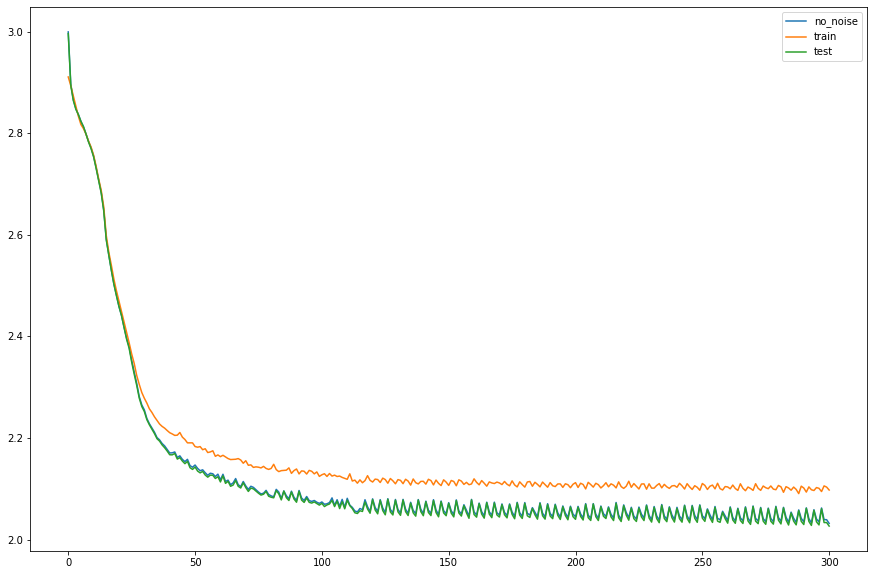

In [0]:
fig, ax = plt.subplots(1, figsize=(15,10))

ax.plot(no_noise_losses)
ax.plot(train_losses)
ax.plot(test_losses)
ax.legend(['no_noise', 'train', 'test'])

# Save model

In [0]:
model_name = f"planar_flow1_4"
flow_model_path = f"{root_path}/plot_notebooks/models_for_plots/{model_name}"

In [0]:
with open(flow_model_path, 'wb') as f:
   # pickle.dump(results_dict, f)

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [0]:
model_name

'planar_flow1_4'

# Visualize model

In [0]:
flow_depth=48

In [0]:
model_name = f"rotating_two_moons_planar_{flow_depth}"
flow_model_path = f"{root_path}/plot_notebooks/models_for_plots/{model_name}"

In [0]:
with open(flow_model_path, 'rb') as f:
    loaded_dict = pickle.load(f)

normalizing_flow = loaded_dict['model']

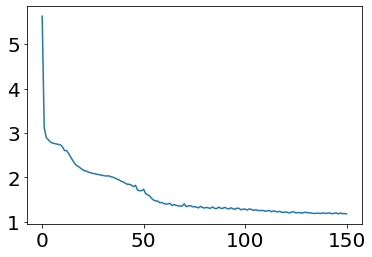

In [0]:
plt.plot(loaded_dict['logs']['test'])

In [0]:
loaded_dict['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 10,
 'c_net_h_dim': 18,
 'clipped_adam': 5,
 'context_dropout': None,
 'context_n_depth': 4,
 'context_n_h_dim': 18,
 'coupling_dropout': None,
 'data_size': 100000,
 'epochs': 1500,
 'flow_depth': 48,
 'l2_reg': None,
 'problem_dim': 2,
 'rich_context_dim': 5}

In [0]:
# Load data
from DEwNF.utils import split_synthetic
batch_size = 500
data_size = 100000
cuda_exp = True
train_dataloader, test_dataloader, obs_scaler, context_scaler = split_synthetic(data_df, batch_size,
                                                    data_size, cuda_exp, random_state=None)

In [0]:
def create_overlay(shape, bounds, flow_dist, obs_scaler):
    cm = matplotlib.cm.get_cmap('cividis')
    
    nlats, nlons = shape
    
    lats_array = torch.linspace(start=bounds[1][0], end=bounds[0][0], steps=nlats).float()
    lons_array = torch.linspace(start=bounds[0][1], end=bounds[1][1], steps=nlons).float()
    x, y = torch.meshgrid(lats_array, lons_array)

    points = torch.stack((x.reshape(-1), y.reshape(-1)), axis=1).cuda()
    scaled_points = torch.tensor(obs_scaler.transform(points.cpu())).float().cuda()
    with torch.no_grad():
        data = flow_dist.log_prob(scaled_points).reshape(nlats,nlons).cpu().detach().numpy()
    
    data = np.exp(data).T # this transpose should not be necesary
    data = (data - data.min()) / (data.max() - data.min())

    overlay = cm(data)
    return lons_array, lats_array, overlay, data

In [0]:

## interactive plot
plt.rcParams.update({'font.size': 20})
cond_two_moons = RotatingTwoMoonsConditionalSampler(noise=0.05)

def model_tester3(theta, flow, obs_scaler, context_scaler):
    flow.modules.eval()
    scaled_theta = torch.tensor(context_scaler.transform([[theta]]))
    context = (scaled_theta).float().cuda()
    cond_dist = flow.condition(context)
    x, _ = cond_two_moons.conditioned_sample(n_samples=512, theta=torch.tensor([theta]))
    bounds = [[-3,-2], [3,2]]
    _,_, _, data = create_overlay(shape = (800,800), bounds=bounds, flow_dist = cond_dist, obs_scaler=obs_scaler)  

    plt.figure(figsize=(12, 10))
    plt.scatter(x[:, 0], x[:, 1], c='r', s=5, alpha=0.5, label="Observations")
    plt.xlim(bounds[0][0],bounds[1][0])
    plt.ylim(bounds[0][1],bounds[1][1])
    test = plt.imshow(data, cmap='cividis', extent=(bounds[1][0],bounds[0][0], bounds[1][1], bounds[0][1]), label="Target distribution")
    plt.legend(framealpha=0.3, fontsize=15, markerscale=6)
    plt.colorbar(test, shrink=0.6)
    plt.show()


interactive_plot = interactive(model_tester3,
                               theta=(0.,2*np.pi),
                               flow=fixed(normalizing_flow),
                               obs_scaler=fixed(obs_scaler),
                               context_scaler=fixed(context_scaler))
interactive_plot




interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), Output…

In [0]:
with open(flow_model_path, 'rb') as f:
    loaded_dict = pickle.load(f)

In [0]:
loaded_flow = loaded_dict['model']

In [0]:
loaded_dict['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 10,
 'c_net_h_dim': 18,
 'clipped_adam': 5,
 'context_dropout': None,
 'context_n_depth': 4,
 'context_n_h_dim': 18,
 'coupling_dropout': None,
 'data_size': 100000,
 'epochs': 3000,
 'flow_depth': 4,
 'l2_reg': None,
 'problem_dim': 2,
 'rich_context_dim': 5}

In [0]:
def create_plot(axs, x, dist, trans_idx, trans_type, obs_scaler):
    bounds = [[-3,-2], [3,2]]
    _, _, _, data = create_overlay(shape = (200,200), bounds=bounds, flow_dist = dist, obs_scaler=obs_scaler)  
    axs.scatter(x[:, 0], x[:, 1], c='r', s=5, alpha=0.5, label="Observations")
    axs.set_xlim(-3,3)
    axs.set_ylim(-2,2)
    axs.set_title(f'After transformation number {trans_idx} ({trans_type})', fontsize=15)
    axs.legend(framealpha=0.3, fontsize=12, markerscale=6)
    
    colors = axs.imshow(data, cmap='cividis', extent=(3,-3, 2, -2))
    return colors
    

In [0]:
def rename_trans(name):
    if name == "ConditionedAffineCoupling2()":
        return "Conditioned Affine Coupling"
    if name == "Permute()":
        return "Permute"
    if name == "BatchNorm()":
        return "Batchnorm"
    if name == "InvertedConditionedPlanar()":
        return "Conditioned Planar Transformation"

def model_tester4(theta, flow):
    flow.modules.eval()
    scaled_theta = torch.tensor(context_scaler.transform([[theta]]))
    context = (scaled_theta).float().cuda()
    cond_dist = flow.condition(context)
    x, _= cond_two_moons.conditioned_sample(n_samples=512, theta=torch.tensor([theta]))
    bounds = [[-3,-2], [3,2]]
    n_trans = len(cond_dist.transforms)
    fig, axs = plt.subplots(((n_trans) // 2) +1 , 2,  figsize=(25,n_trans*5),gridspec_kw = {'wspace':0, 'hspace':0})

    colors = create_plot(axs[0, 0], x, cond_dist.base_dist.to_event(1), 0, 'Base distribution', obs_scaler)
    plt.colorbar(colors, ax=axs[0,0], shrink=0.8)
    for i in range(0, n_trans):
        temp_dist = TransformedDistribution(cond_dist.base_dist, cond_dist.transforms[0:i+1])
        trans_type = rename_trans(cond_dist.transforms[i].__str__())
        colors = create_plot(axs[(i+1) // 2, (i+1) % 2 ], x, temp_dist, i+1, trans_type, obs_scaler)
        plt.colorbar(colors, ax=axs[(i+1) // 2, (i+1) % 2 ],shrink=0.8)
    if n_trans % 2 == 0:
        fig.delaxes(axs[n_trans//2, 1])

interactive_plot = interactive(model_tester4,
                               theta=(0.,2*np.pi),
                               flow=fixed(normalizing_flow))
interactive_plot


interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), Output…

In [0]:

interactive_plot = interactive(model_tester4,
                               theta=(0.,2*np.pi),
                               moon=(0.,1.,1),
                               trans_1=(-4.,4.),
                               trans_2=(-4.,4.),
                               flow_dist=fixed(loaded_flow.dist))
interactive_plot


ValueError: ignored